# Requirements

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('default')
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten, Input, concatenate
from keras.layers import ConvLSTM2D
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3536997302047404106
xla_global_id: -1
]


# Loading Data

In [ ]:
augmented_new_all_inserted_preprocessed = pd.read_csv("/content/drive/MyDrive/Augmented Data/augmented_new_all_inserted_preprocessed.csv",index_col = 0)
augmented_new_all_inserted_preprocessed = augmented_new_all_inserted_preprocessed.sort_index()
raw_copy = pd.read_csv('/content/drive/MyDrive/New Fetal Growth Data/raw_copy.csv',index_col = 0)
augmented_new_all_inserted = pd.read_csv("/content/drive/MyDrive/New Fetal Growth Data/augmented_new_all_inserted.csv",index_col = 0)
augmented_new_nl_inserted = pd.read_csv("/content/drive/MyDrive/Augmented Data/augmented_new_nl_inserted.csv",index_col = 0)

augmented_new_inserted_preprocessed = pd.read_csv("/content/drive/MyDrive/Augmented Data/augmented_new_inserted_preprocessed.csv",index_col = 0)
augmented_new_inserted_preprocessed = augmented_new_inserted_preprocessed.iloc[:,:218]

no_covariate_no_na_clean = pd.read_csv("/content/drive/MyDrive/New Fetal Growth Data/no_covariate_no_na_clean.csv",index_col = 0)

In [ ]:
print("Verifying the data is of correct length......")
if sum(augmented_new_nl_inserted.id.unique() == augmented_new_inserted_preprocessed.index) == augmented_new_inserted_preprocessed.shape[0]:
  print("Data is correctly loaded.")

Verifying the data is of correct length......
Data is correctly loaded.


# Creating Covariates 
`covariates_5_record` contains the covariate information of the subjects with all 5 records.

In [ ]:
raw_copy_5_record = raw_copy.loc[raw_copy.id.isin(augmented_new_nl_inserted.id)]
covariates_5_record = raw_copy_5_record[['id','wt_before_preg','height','NoPrevPreg','hpb','cardiac','baseline_diabetes','renal','reg_smoke']]
covariates_5_record = covariates_5_record.iloc[0:1125,:]
covariates_5_record

,id,wt_before_preg,height,NoPrevPreg,hpb,cardiac,baseline_diabetes,renal,reg_smoke
1,3,56.0,163.0,1.0,0.0,0.0,0.0,0.0,0.0
2,5,61.0,166.0,1.0,0.0,0.0,0.0,0.0,0.0
3,6,53.0,158.0,1.0,0.0,0.0,0.0,0.0,1.0
4,7,50.0,164.0,1.0,0.0,0.0,0.0,0.0,1.0
5,38,53.0,164.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2038,9619,56.0,169.0,1.0,0.0,0.0,0.0,0.0,1.0
2047,9691,65.0,170.0,1.0,0.0,0.0,0.0,0.0,1.0
2059,9763,49.0,160.0,2.0,0.0,0.0,0.0,0.0,1.0
2062,9811,65.0,160.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
sum(raw_copy_5_record.id.unique() == augmented_new_inserted_preprocessed.index)

1125

In [ ]:
raw_copy_543_record = raw_copy.loc[raw_copy.id.isin(augmented_new_all_inserted_preprocessed.index)]
covariates_543_record = raw_copy_543_record[['id','hpb','cardiac','baseline_diabetes','renal','reg_smoke']]
covariates_543_record = covariates_543_record.iloc[:len(raw_copy_543_record.id.unique()),:]

In [ ]:
sum(covariates_543_record.id == augmented_new_all_inserted_preprocessed.sort_index().index)

1612

# Model Building Functions

## Setting X and y, Fixed X and y length

In [9]:
def set_X_and_y(df,y_days):
  """
    @param df: the pre-processed dataframe
    @param y_days: the amount of days y contains
  """
  y = df.iloc[:,-y_days:]
  X = df.drop(columns = y.columns)
  print("X and y are now set up:")
  print("X contains",X.shape[1],"days,")
  print("y contains",y.shape[1],"days.")

  return X,y

## Preprocess Functions

In [10]:
def preprocess_regular(X_train, X_test, y_train, y_test,n_features = 1):
  """regular data preprocessing
     @param X_train, X_test:  input
     @param y_train, y_test:  output
     @param n_features

  """

  
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  y_train_scaled = scaler.fit_transform(y_train)
  X_test_scaled = scaler.fit_transform(X_test)
  y_test_scaled = scaler.fit_transform(y_test)
  
  X_train_scaled = X_train_scaled.reshape(X_train.shape[0],X_train.shape[1],n_features)
  X_test_scaled = X_test_scaled.reshape(X_test.shape[0],X_test.shape[1],n_features)

  return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler

## Functions for Classification Metrics

In [12]:
sga_lga = pd.read_csv('/content/drive/MyDrive/sga_lga.csv',header = 1, index_col = 0,thousands=',')

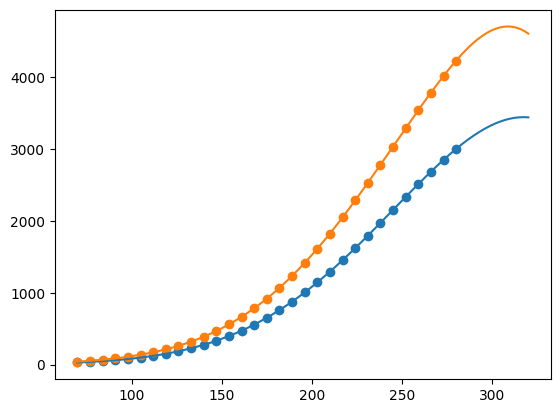

In [38]:
from scipy.interpolate import make_interp_spline
interpolation_spline_90 = make_interp_spline(sga_lga['90th'].index.values*7, sga_lga['90th'].values,k=3)

interpolation_spline_10 = make_interp_spline(sga_lga['10th'].index.values*7, sga_lga['10th'].values,k=3)

total_gadays = np.linspace(sga_lga['90th'].index.values.min()*7,sga_lga['90th'].index.values.max()*7+40,\
                           sga_lga['90th'].index.values.max()*7+40- sga_lga['90th'].index.values.min()*7+1)

bw_90th = interpolation_spline_90(total_gadays)
bw_10th = interpolation_spline_10(total_gadays)

df_90th_10th = pd.DataFrame(np.hstack([total_gadays.reshape(-1,1),bw_90th.reshape(-1,1),bw_10th.reshape(-1,1)]))
df_90th_10th.columns = ['gadays','90th percentile BW','10th percentile BW']
plt.plot(total_gadays,bw_10th)
plt.scatter(sga_lga['10th'].index.values*7, sga_lga['10th'].values)

plt.plot(total_gadays,bw_90th)
plt.scatter(sga_lga['90th'].index.values*7, sga_lga['90th'].values)

In [39]:
df_90th_10th

,gadays,90th percentile BW,10th percentile BW
0,70.0,41.000000,29.000000
1,71.0,42.406170,29.901906
2,72.0,43.930999,30.891472
3,73.0,45.564915,31.964293
4,74.0,47.298346,33.115962
...,...,...,...
246,316.0,4667.982401,3444.602679
247,317.0,4655.833334,3445.269498
248,318.0,4641.995538,3445.156926
249,319.0,4626.438981,3444.252817


In [82]:
def is_lga(y,full_record_data,df_90th_10th):
    """convert float list into a list of booleans
     (LGA), which describes an infant with a 90th percentile or
     higher birthweight for gestational age
     @param y
     @param raw_copy
     @df_90th_10th
     """
    result = []
    for id in y.index:
      birthday = float(full_record_data[full_record_data.id == id].birthday.values[0])
      result.append(y[y.index == id].values >= df_90th_10th.loc[(df_90th_10th['gadays'] == birthday),'90th percentile BW'])
    return np.array(result).reshape(-1,)

def is_sga(y,full_record_data,df_90th_10th):
    """convert float list into a list of booleans
     (SGA), which describes an infant with a 10th percentile or
     lower birthweight for gestational age
     @param y
     @param raw_copy
     @df_90th_10th
     """
    result = []
    for id in y.index:
      birthday = float(full_record_data[full_record_data.id == id].birthday.values[0])
      result.append(y[y.index == id].values < df_90th_10th.loc[(df_90th_10th['gadays'] == birthday),'10th percentile BW'])
    return np.array(result).reshape(-1,)


def is_macro(y):
    """convert float list into a list of booleans
    “macrosomia”is used to describe the condition of 
    a fetus with a birth weight of more than 4000 g."""
    return y>4000

def is_lbw(y):
    """convert float list into a list of booleans
    a subject is low birth weight (lbw) gives birth to
    a fetus with a birth weight of less than 2500 g."""
    return y<2500

## Functions to Run and Evaluate Models

In [14]:
def train_model(model, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler, X_test, y_test):
  """Runs the input model using preprocessed and scaled data

     @param X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled: 
     Data. Note that X_train_scaled and X_test_scaled can be concatenated arrays

     @param model: the compiled, untrained model
     @param scaler: the original scaler used for retaining original data
     @para X_test, y_test: the unscaled X_test and y_test

  """
  print("Training model....")
  training_history = model.fit(X_train_scaled,y_train_scaled,epochs = 20,validation_data=(X_test_scaled, y_test_scaled))
  print("Done!")
  test_eval = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
  print("Testing loss is",test_eval)
  
  pred_y = model.predict(X_test_scaled)
  true_pred = scaler.inverse_transform(pred_y)


  test_data = pd.concat([X_test,y_test],axis = 1)

  predicted_y_test = pd.DataFrame(true_pred)
  predicted_y_test.columns = y_test.columns
  predicted_y_test = predicted_y_test.set_index(y_test.index)
  test_data_pred = pd.concat([X_test,predicted_y_test],axis = 1)

  return test_data_pred,test_data

In [15]:
def generate_test_weight_new(pred_df, original_df, full_record_data):
  """
  pred_df,origindal_df,
  """
  print("Building Comparison Dataframe")
  test_weight = []
  for id in original_df.index:
    birthday = float(full_record_data[full_record_data.id == id].birthday.values[0])
    pred_bw = pred_df[pred_df.index == id][str(birthday)].values[0]
    real_bw = original_df[original_df.index == id][str(birthday)].values[0]
    test_weight.append(np.array([pred_bw,real_bw]).reshape(-1,))

  print("Done. 'test_weight' contains predicted bw vs real bw.")
  test_weight = pd.DataFrame(test_weight)
  test_weight.columns = ["Predicted BW","Real BW"]
  test_weight = test_weight.set_index(original_df.index)
  
  return test_weight

In [97]:
def evaluate_test_weight(df,full_record_data,df_90th_10th):
  """
  returns classification metrics for df
  """
  true_pred = df['Predicted BW']
  true_y_test = df['Real BW']
  mae = mean_absolute_error(true_y_test,true_pred)
  print("Mean absolute error of the predicted weights is",mae)

  lga_true = is_lga(true_y_test,full_record_data,df_90th_10th)
  macro_true = is_macro(true_y_test)
  lga_pred = is_lga(true_pred,full_record_data,df_90th_10th)
  macro_pred = is_macro(true_pred)

  sga_true = is_sga(true_y_test,full_record_data,df_90th_10th)
  lbw_true = is_lbw(true_y_test)
  sga_pred = is_sga(true_pred,full_record_data,df_90th_10th)
  lbw_pred = is_lbw(true_pred)

  cm_lga = metrics.confusion_matrix(lga_true,lga_pred)
  cm_macro = metrics.confusion_matrix(macro_true,macro_pred)
  cm_sga = metrics.confusion_matrix(sga_true,sga_pred)
  cm_lbw = metrics.confusion_matrix(lbw_true,lbw_pred)

  tn_lga, fp_lga, fn_lga, tp_lga = cm_lga.ravel()
  tn_macro, fp_macro, fn_macro, tp_macro = cm_macro.ravel()
  tn_sga, fp_sga, fn_sga, tp_sga = cm_sga.ravel()
  tn_lbw, fp_lbw, fn_lbw, tp_lbw = cm_lbw.ravel()
  
  PPV_lga = round( tp_lga / (tp_lga+fp_lga),4 )
  PPV_macro = round( tp_macro / (tp_macro+fp_macro),4 )
  NPV_lga = round( tn_lga / (tn_lga+fn_lga),4 )
  NPV_macro = round( tn_macro / (tn_macro+fn_macro),4 )

  PPV_sga = round( tp_sga / (tp_sga+fp_sga),4 )
  PPV_lbw = round( tp_lbw / (tp_lbw+fp_lbw),4 )
  NPV_sga = round( tn_sga / (tn_sga+fn_sga),4 )
  NPV_lbw = round( tn_lbw / (tn_lbw+fn_lbw),4 )


  sensitivity_lga = metrics.classification_report(lga_true,lga_pred,output_dict=True)['True']['recall']
  specificity_lga = metrics.classification_report(lga_true,lga_pred,output_dict=True)['False']['recall']
  PLR_lga = sensitivity_lga / (1-specificity_lga)
  NLR_lga = (1-sensitivity_lga)/specificity_lga
  
  sensitivity_macro = metrics.classification_report(macro_true,macro_pred,output_dict=True)['True']['recall']
  specificity_macro = metrics.classification_report(macro_true,macro_pred,output_dict=True)['False']['recall']
  PLR_macro = sensitivity_macro / (1-specificity_macro)
  NLR_macro = (1-sensitivity_macro)/specificity_macro

  sensitivity_sga = metrics.classification_report(sga_true,sga_pred,output_dict=True)['True']['recall']
  specificity_sga = metrics.classification_report(sga_true,sga_pred,output_dict=True)['False']['recall']
  PLR_sga = sensitivity_sga / (1-specificity_sga+0.001)
  NLR_sga = (1-sensitivity_sga)/specificity_sga
  
  sensitivity_lbw = metrics.classification_report(lbw_true,lbw_pred,output_dict=True)['True']['recall']
  specificity_lbw = metrics.classification_report(lbw_true,lbw_pred,output_dict=True)['False']['recall']
  PLR_lbw = sensitivity_lbw / (1-specificity_lbw+0.001)
  NLR_lbw = (1-sensitivity_lbw)/specificity_lbw


  model_metrics = pd.DataFrame(columns=(['Classification','MAE','Accuracy','ROC_AUC','Sensitivity','Specificity','PPV','NPV','PLR','NLR']))
  model_metrics = model_metrics.append({'Classification':'LGA','MAE':mae,'Accuracy':metrics.accuracy_score(lga_true,lga_pred),\
                                        'ROC_AUC':metrics.roc_auc_score(lga_true,lga_pred),'Sensitivity':sensitivity_lga,'Specificity':specificity_lga,\
                                        'PPV':PPV_lga,'NPV':NPV_lga,'PLR':PLR_lga,'NLR':NLR_lga},ignore_index = True)
  model_metrics = model_metrics.append({'Classification':'Macro','MAE':mae,'Accuracy':metrics.accuracy_score(macro_true,macro_pred),\
                                        'ROC_AUC':metrics.roc_auc_score(macro_true,macro_pred),'Sensitivity':sensitivity_macro,'Specificity':specificity_macro,\
                                        'PPV':PPV_macro,'NPV':NPV_macro,'PLR':PLR_macro,'NLR':NLR_macro},ignore_index = True)
  
  model_metrics = model_metrics.append({'Classification':'SGA','MAE':mae,'Accuracy':metrics.accuracy_score(sga_true,sga_pred),\
                                        'ROC_AUC':metrics.roc_auc_score(sga_true,sga_pred),'Sensitivity':sensitivity_sga,'Specificity':specificity_sga,\
                                        'PPV':PPV_sga,'NPV':NPV_sga,'PLR':PLR_sga,'NLR':NLR_sga},ignore_index = True)
  model_metrics = model_metrics.append({'Classification':'LBW','MAE':mae,'Accuracy':metrics.accuracy_score(lbw_true,lbw_pred),\
                                        'ROC_AUC':metrics.roc_auc_score(lbw_true,lbw_pred),'Sensitivity':sensitivity_lbw,'Specificity':specificity_lbw,\
                                        'PPV':PPV_lbw,'NPV':NPV_lbw,'PLR':PLR_lbw,'NLR':NLR_lbw},ignore_index = True)
  return model_metrics

# Model Runs 

## model runs on 5-record data

In [108]:
birthday_min = raw_copy_5_record.birthday.describe()['min']
birthday_max = raw_copy_5_record.birthday.describe()['max']
print("Use days",round(birthday_min),'to',round(birthday_max),"as y")
y_days = int(birthday_max - round(birthday_min)+1)
X,y = set_X_and_y(augmented_new_inserted_preprocessed,y_days)


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 13)
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler = preprocess_regular(X_train, X_test, y_train, y_test)
n_steps, n_features,n_output  = X_train_scaled.shape[1], X_train_scaled.shape[2], y_train_scaled.shape[1]

Use days 249 to 301 as y
X and y are now set up:
X contains 165 days,
y contains 53 days.


### model with no covariates

In [109]:
inp = Input(shape=(n_steps, n_features))
x = LSTM(256)(inp)
out = Dense(n_output, activation="relu")(x)
model_no_covariate = Model(inputs=inp, outputs=out)
model_no_covariate.compile(optimizer="adam", loss='mse')
print(model_no_covariate.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 165, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense_1 (Dense)             (None, 53)                13621     
                                                                 
Total params: 277,813
Trainable params: 277,813
Non-trainable params: 0
_________________________________________________________________
None


In [110]:
test_data_pred, test_data = train_model(model_no_covariate,\
                                        X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler,\
                                        X_test, y_test)

Training model....
Epoch 1/20
25/25 [==============================] - 17s 578ms/step - loss: 0.6729 - val_loss: 0.5228
Epoch 2/20
25/25 [==============================] - 13s 533ms/step - loss: 0.4774 - val_loss: 0.4710
Epoch 3/20
25/25 [==============================] - 14s 543ms/step - loss: 0.4589 - val_loss: 0.4704
Epoch 4/20
25/25 [==============================] - 14s 555ms/step - loss: 0.4578 - val_loss: 0.4747
Epoch 5/20
25/25 [==============================] - 14s 553ms/step - loss: 0.4631 - val_loss: 0.4768
Epoch 6/20
25/25 [==============================] - 14s 553ms/step - loss: 0.4611 - val_loss: 0.4701
Epoch 7/20
25/25 [==============================] - 14s 554ms/step - loss: 0.4574 - val_loss: 0.4703
Epoch 8/20
25/25 [==============================] - 14s 552ms/step - loss: 0.4574 - val_loss: 0.4701
Epoch 9/20
25/25 [==============================] - 14s 561ms/step - loss: 0.4576 - val_loss: 0.4723
Epoch 10/20
25/25 [==============================] - 14s 545ms/step - lo

In [ ]:
result_5_no_covariate = generate_test_weight_new(test_data_pred, test_data,raw_copy_5_record)
result_metrics_5_no_covariate = evaluate_test_weight(result_5_no_covariate,raw_copy_5_record,df_90th_10th)
result_metrics_5_no_covariate

In [ ]:
result_metrics_5_no_covariate.to_csv("result_metrics_5_no_covariate.csv")

!cp result_metrics_5_no_covariate.csv "/content/drive/MyDrive/New Data Results"

### model with covariates

In [21]:
scalar_1 = StandardScaler()
covariates_5_record.wt_before_preg = scalar_1.fit_transform(np.array(covariates_5_record.wt_before_preg).reshape(-1,1))
covariates_5_record.height = scalar_1.fit_transform(np.array(covariates_5_record.height).reshape(-1,1))

In [22]:
covariates_5_record = covariates_5_record.fillna(0)
covariates_train = covariates_5_record[covariates_5_record.id.isin(X_train.index)].iloc[:,1:]
covariates_test = covariates_5_record[covariates_5_record.id.isin(X_test.index)].iloc[:,1:]

In [23]:
covariates_5_record

,id,wt_before_preg,height,NoPrevPreg,hpb,cardiac,baseline_diabetes,renal,reg_smoke
1,3,-0.320406,-0.493229,1.0,0.0,0.0,0.0,0.0,0.0
2,5,0.180117,0.009264,1.0,0.0,0.0,0.0,0.0,0.0
3,6,-0.620720,-1.330717,1.0,0.0,0.0,0.0,0.0,1.0
4,7,-0.921034,-0.325731,1.0,0.0,0.0,0.0,0.0,1.0
5,38,-0.620720,-0.325731,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2038,9619,-0.320406,0.511757,1.0,0.0,0.0,0.0,0.0,1.0
2047,9691,0.580535,0.679254,1.0,0.0,0.0,0.0,0.0,1.0
2059,9763,-1.021138,-0.995722,2.0,0.0,0.0,0.0,0.0,1.0
2062,9811,0.580535,-0.995722,1.0,0.0,0.0,0.0,0.0,1.0


In [24]:
seq_inp = Input(shape=(n_steps, n_features))
nonseq_inp = Input(shape = (covariates_train.shape[1],))
x = SimpleRNN(256)(seq_inp)
x = concatenate([x, nonseq_inp])
out = Dense(n_output, activation="relu")(x)
model_w_covariates = Model(inputs=[seq_inp, nonseq_inp], outputs=out)
model_w_covariates.compile(optimizer="adam", loss='mse')
print(model_w_covariates.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 165, 1)]     0           []                               
                                                                                                  
 simple_rnn (SimpleRNN)         (None, 256)          66048       ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 264)          0           ['simple_rnn[0][0]',             
                                                                  'input_2[0][0]']            

In [92]:
test_data_pred, test_data = train_model(model_w_covariates,\
                                        [X_train_scaled,covariates_train], y_train_scaled,\
                                        [X_test_scaled,covariates_test], y_test_scaled, scaler,\
                                        X_test, y_test)

Training model....
Epoch 1/20
25/25 [==============================] - 3s 127ms/step - loss: 0.4590 - val_loss: 0.4720
Epoch 2/20
25/25 [==============================] - 3s 123ms/step - loss: 0.4584 - val_loss: 0.4719
Epoch 3/20
25/25 [==============================] - 3s 121ms/step - loss: 0.4586 - val_loss: 0.4714
Epoch 4/20
25/25 [==============================] - 3s 121ms/step - loss: 0.4585 - val_loss: 0.4716
Epoch 5/20
25/25 [==============================] - 3s 122ms/step - loss: 0.4584 - val_loss: 0.4714
Epoch 6/20
25/25 [==============================] - 3s 123ms/step - loss: 0.4585 - val_loss: 0.4724
Epoch 7/20
25/25 [==============================] - 3s 122ms/step - loss: 0.4585 - val_loss: 0.4713
Epoch 8/20
25/25 [==============================] - 3s 122ms/step - loss: 0.4581 - val_loss: 0.4711
Epoch 9/20
25/25 [==============================] - 3s 124ms/step - loss: 0.4582 - val_loss: 0.4720
Epoch 10/20
25/25 [==============================] - 3s 122ms/step - loss: 0.4589

In [115]:
result_5_covariate = generate_test_weight_new(test_data_pred, test_data,raw_copy_5_record)
result_metrics_5_covariate = evaluate_test_weight(result_5_covariate,raw_copy_5_record,df_90th_10th)
result_metrics_5_covariate

Building Comparison Dataframe
Done. 'test_weight' contains predicted bw vs real bw.
Mean absolute error of the predicted weights is 280.80588242751656


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are il

,Classification,MAE,Accuracy,ROC_AUC,Sensitivity,Specificity,PPV,NPV,PLR,NLR
0,LGA,280.805882,0.961538,0.900848,0.827586,0.974110,0.7500,0.9837,31.965517,0.176996
1,Macro,280.805882,0.834320,0.890523,0.985507,0.795539,0.5528,0.9953,4.820026,0.018218
2,SGA,280.805882,0.931953,0.500000,0.000000,1.000000,NaN,0.9320,0.000000,1.000000
3,LBW,280.805882,0.994083,0.500000,0.000000,1.000000,NaN,0.9941,0.000000,1.000000


In [99]:
sga_pred = is_sga(result_5_covariate['Predicted BW'],raw_copy_5_record,df_90th_10th)
sga_true = is_sga(result_5_covariate['Real BW'],raw_copy_5_record,df_90th_10th)
metrics.confusion_matrix(sga_true,sga_pred)

array([[315,   0],
       [ 23,   0]])

In [124]:
macro_pred = is_macro(result_5_covariate['Predicted BW'])
macro_true = is_macro(result_5_covariate['Real BW'])
cm_macro = metrics.confusion_matrix(macro_true,macro_pred)
tn_macro, fp_macro, fn_macro, tp_macro = cm_macro.ravel()

In [125]:
tp_macro/(fn_macro+tp_macro)

0.9855072463768116

In [114]:
print(metrics.classification_report(macro_true,macro_pred))

              precision    recall  f1-score   support

       False       1.00      0.80      0.89       269
        True       0.56      1.00      0.72        69

    accuracy                           0.84       338
   macro avg       0.78      0.90      0.80       338
weighted avg       0.91      0.84      0.85       338



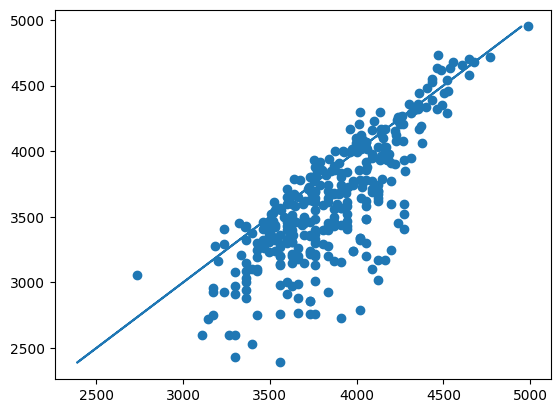

In [91]:
plt.scatter(result_5_covariate['Predicted BW'],result_5_covariate['Real BW'])
plt.plot(result_5_covariate['Real BW'],result_5_covariate['Real BW'])

In [128]:
sum(result_5_covariate['Real BW']>4000),sum(result_5_covariate['Predicted BW']>4000)

(69, 123)

In [27]:
result_metrics_5_covariate.to_csv("result_metrics_5_covariate.csv")
!cp result_metrics_5_covariate.csv "/content/drive/MyDrive/New Data Results"

## model runs on 5/4/3 record data (1612 ids, including early birthdays)

In [ ]:
birthday_min = raw_copy_543_record.birthday.describe()['min']
birthday_max = raw_copy_543_record.birthday.describe()['max']
print("Use days",round(birthday_min),'to',round(birthday_max),"as y")
y_days = int(birthday_max - round(birthday_min)+1)
X,y = set_X_and_y(augmented_new_all_inserted_preprocessed,y_days)


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 13)
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler = preprocess_regular(X_train, X_test, y_train, y_test)
n_steps, n_features,n_output  = X_train_scaled.shape[1], X_train_scaled.shape[2], y_train_scaled.shape[1]

Use days 178 to 303 as y
X and y are now set up:
X contains 95 days,
y contains 126 days.


### model with no covariates

In [ ]:
inp = Input(shape=(n_steps, n_features))
x = SimpleRNN(256)(inp)
out = Dense(n_output, activation="relu")(x)
model_no_covariate = Model(inputs=inp, outputs=out)
model_no_covariate.compile(optimizer="adam", loss='mse')
print(model_no_covariate.summary())

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 95, 1)]           0         
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 256)               66048     
                                                                 
 dense_13 (Dense)            (None, 126)               32382     
                                                                 
Total params: 98,430
Trainable params: 98,430
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
test_data_pred, test_data = train_model(model_no_covariate,\
                                        X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler,\
                                        X_test, y_test)

Training model....
Epoch 1/10
36/36 [==============================] - 3s 52ms/step - loss: 0.7359 - val_loss: 0.6627
Epoch 2/10
36/36 [==============================] - 2s 46ms/step - loss: 0.6592 - val_loss: 0.6283
Epoch 3/10
36/36 [==============================] - 2s 46ms/step - loss: 0.6480 - val_loss: 0.6163
Epoch 4/10
36/36 [==============================] - 2s 49ms/step - loss: 0.6219 - val_loss: 0.6064
Epoch 5/10
36/36 [==============================] - 2s 61ms/step - loss: 0.6430 - val_loss: 0.6292
Epoch 6/10
36/36 [==============================] - 2s 68ms/step - loss: 0.6209 - val_loss: 0.6242
Epoch 7/10
36/36 [==============================] - 2s 54ms/step - loss: 0.6331 - val_loss: 0.6156
Epoch 8/10
36/36 [==============================] - 2s 54ms/step - loss: 0.6448 - val_loss: 0.6146
Epoch 9/10
36/36 [==============================] - 2s 52ms/step - loss: 0.6631 - val_loss: 0.6916
Epoch 10/10
36/36 [==============================] - 2s 53ms/step - loss: 0.6668 - val_los

In [ ]:
result_543_no_covariate = generate_test_weight_new(test_data_pred, test_data,raw_copy_543_record)
result_metrics_543_no_covariate = evaluate_test_weight(result_543_no_covariate)
result_metrics_543_no_covariate

Building Comparison Dataframe
Done. 'test_weight' contains predicted bw vs real bw.
Mean absolute error of the predicted weights is 321.83628282098965
For LGA classification, the accuracy is 0.8966942148760331 , the ROC_AUC score is 0.7173844133496354 , sensitivity is 0.49019607843137253 , and specificity is 0.9445727482678984
For Macrosomia classification, the accuracy is 0.8285123966942148 , the ROC_AUC score is 0.7313016027197669 , sensitivity is 0.603448275862069 , and specificity is 0.8591549295774648
See the returned table for more details.


,Classification,MAE,Accuracy,ROC_AUC,Sensitivity,Specificity,PPV,NPV,PLR,NLR
0,LGA,321.836283,0.896694,0.717384,0.490196,0.944573,0.5102,0.9402,8.843954,0.539719
1,Macro,321.836283,0.828512,0.731302,0.603448,0.859155,0.3684,0.9409,4.284483,0.461560


In [ ]:
result_metrics_543_no_covariate.to_csv("result_metrics_543_no_covariate.csv")
!cp result_metrics_543_no_covariate.csv "/content/drive/MyDrive/New Data Results"

### model with covariates

In [ ]:
covariates_543_record = covariates_543_record.fillna(0)
covariates_train = covariates_543_record[covariates_543_record.id.isin(X_train.index)].iloc[:,1:]
covariates_test = covariates_543_record[covariates_543_record.id.isin(X_test.index)].iloc[:,1:]

In [ ]:
covariates_543_record

,id,hpb,cardiac,baseline_diabetes,renal,reg_smoke
1,3,0.0,0.0,0.0,0.0,0.0
2,5,0.0,0.0,0.0,0.0,0.0
3,6,0.0,0.0,0.0,0.0,1.0
4,7,0.0,0.0,0.0,0.0,1.0
5,38,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
2067,9879,0.0,0.0,0.0,1.0,1.0
2069,9882,1.0,0.0,0.0,0.0,0.0
2070,9905,0.0,0.0,0.0,0.0,0.0
2071,9908,0.0,0.0,0.0,0.0,1.0


In [ ]:
seq_inp = Input(shape=(n_steps, n_features))
nonseq_inp = Input(shape = (covariates_train.shape[1],))
x = SimpleRNN(256)(seq_inp)
x = concatenate([x, nonseq_inp])
out = Dense(n_output, activation="relu")(x)
model_w_covariates = Model(inputs=[seq_inp, nonseq_inp], outputs=out)
model_w_covariates.compile(optimizer="adam", loss='mse')
print(model_w_covariates.summary())

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 95, 1)]      0           []                               
                                                                                                  
 simple_rnn_13 (SimpleRNN)      (None, 256)          66048       ['input_23[0][0]']               
                                                                                                  
 input_24 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 concatenate_8 (Concatenate)    (None, 261)          0           ['simple_rnn_13[0][0]',          
                                                                  'input_24[0][0]']        

In [ ]:
test_data_pred, test_data = train_model(model_w_covariates,\
                                        [X_train_scaled,covariates_train], y_train_scaled,\
                                        [X_test_scaled,covariates_test], y_test_scaled, scaler,\
                                        X_test, y_test)

Training model....
Epoch 1/10
36/36 [==============================] - 4s 80ms/step - loss: 0.7613 - val_loss: 0.7247
Epoch 2/10
36/36 [==============================] - 2s 63ms/step - loss: 0.8364 - val_loss: 0.8011
Epoch 3/10
36/36 [==============================] - 2s 67ms/step - loss: 0.6649 - val_loss: 0.6036
Epoch 4/10
36/36 [==============================] - 2s 65ms/step - loss: 0.5679 - val_loss: 0.5736
Epoch 5/10
36/36 [==============================] - 2s 55ms/step - loss: 0.5745 - val_loss: 0.6622
Epoch 6/10
36/36 [==============================] - 2s 57ms/step - loss: 0.5627 - val_loss: 0.5622
Epoch 7/10
36/36 [==============================] - 2s 50ms/step - loss: 0.5585 - val_loss: 0.7394
Epoch 8/10
36/36 [==============================] - 2s 58ms/step - loss: 0.6266 - val_loss: 0.5757
Epoch 9/10
36/36 [==============================] - 2s 56ms/step - loss: 0.6376 - val_loss: 0.6968
Epoch 10/10
36/36 [==============================] - 2s 53ms/step - loss: 0.5934 - val_los

In [ ]:
result_543_covariate = generate_test_weight_new(test_data_pred, test_data,raw_copy_543_record)
result_metrics_543_covariate = evaluate_test_weight(result_543_covariate)
result_metrics_543_covariate

Building Comparison Dataframe
Done. 'test_weight' contains predicted bw vs real bw.
Mean absolute error of the predicted weights is 308.1342776395589
For LGA classification, the accuracy is 0.9256198347107438 , the ROC_AUC score is 0.7940950052076258 , sensitivity is 0.6274509803921569 , and specificity is 0.9607390300230947
For Macrosomia classification, the accuracy is 0.8553719008264463 , the ROC_AUC score is 0.8433705682370081 , sensitivity is 0.8275862068965517 , and specificity is 0.8591549295774648
See the returned table for more details.


,Classification,MAE,Accuracy,ROC_AUC,Sensitivity,Specificity,PPV,NPV,PLR,NLR
0,LGA,308.134278,0.925620,0.794095,0.627451,0.960739,0.6531,0.9563,15.981546,0.387773
1,Macro,308.134278,0.855372,0.843371,0.827586,0.859155,0.4444,0.9734,5.875862,0.200678


In [ ]:
result_metrics_543_covariate.to_csv("result_metrics_543_covariate.csv")
!cp result_metrics_543_covariate.csv "/content/drive/MyDrive/New Data Results"

## model runs with cleaned 5/4/3 record data

### cleaning 5/4/3 data

In [ ]:
raw_copy_543_record[raw_copy_543_record.id == 850]

,id,MoDOB,MoMOB,MoYOB,NoPrevPreg,first_birth_wt,second_birth_wt,hpb,cardiac,baseline_diabetes,...,birthdays33,birthdays37,diabetes_t,BPD,MAD,FEMUR,exam.date,gadays,efw,birthday
276,850,19,8,57,1.0,0.0,NaN,0.0,0.0,0.0,...,270.0,269.0,0,36.0,33.0,26.0,1986-04-10,102.0,179.009899,267.0
2348,850,19,8,57,1.0,0.0,NaN,0.0,0.0,0.0,...,270.0,269.0,0,68.0,74.0,53.0,1986-06-16,175.0,1131.276346,267.0
4420,850,19,8,57,1.0,0.0,NaN,0.0,0.0,0.0,...,270.0,269.0,0,87.0,97.0,65.0,1986-08-12,234.0,2421.270943,267.0
6492,850,19,8,57,1.0,0.0,NaN,0.0,0.0,0.0,...,270.0,269.0,0,91.0,NaN,NaN,1986-09-01,253.0,NaN,267.0


In [ ]:
len(raw_copy_543_record[raw_copy_543_record.birthday > 248].id.unique())

1571

In [ ]:
raw_copy_543_record_cleaned = raw_copy_543_record[raw_copy_543_record.birthday > 248]
covariates_543_record_cleaned = covariates_543_record[covariates_543_record.id.\
                                                      isin(raw_copy_543_record[raw_copy_543_record.birthday > 248].id.unique())]

augmented_new_all_inserted_preprocessed_cleaned =augmented_new_all_inserted_preprocessed[augmented_new_all_inserted_preprocessed.\
                                                                                         index.\
                                                                                         isin(raw_copy_543_record[raw_copy_543_record.birthday > 248].id.unique())]

In [ ]:
birthday_min = raw_copy_543_record_cleaned.birthday.describe()['min']
birthday_max = raw_copy_543_record_cleaned.birthday.describe()['max']
print("Use days",round(birthday_min),'to',round(birthday_max),"as y")
y_days = int(birthday_max - round(birthday_min)+1)
X,y = set_X_and_y(augmented_new_all_inserted_preprocessed_cleaned,y_days)


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 13)
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler = preprocess_regular(X_train, X_test, y_train, y_test)
n_steps, n_features,n_output  = X_train_scaled.shape[1], X_train_scaled.shape[2], y_train_scaled.shape[1]

Use days 249 to 303 as y
X and y are now set up:
X contains 166 days,
y contains 55 days.


### model with no covariates

In [ ]:
inp = Input(shape=(n_steps, n_features))
x = SimpleRNN(256)(inp)
out = Dense(n_output, activation="relu")(x)
model_no_covariate = Model(inputs=inp, outputs=out)
model_no_covariate.compile(optimizer="adam", loss='mse')
print(model_no_covariate.summary())

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 166, 1)]          0         
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 256)               66048     
                                                                 
 dense_15 (Dense)            (None, 55)                14135     
                                                                 
Total params: 80,183
Trainable params: 80,183
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
test_data_pred, test_data = train_model(model_no_covariate,\
                                        X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler,\
                                        X_test, y_test)

Training model....
Epoch 1/10
35/35 [==============================] - 4s 105ms/step - loss: 0.6165 - val_loss: 0.4954
Epoch 2/10
35/35 [==============================] - 3s 80ms/step - loss: 0.4930 - val_loss: 0.4848
Epoch 3/10
35/35 [==============================] - 3s 79ms/step - loss: 0.4870 - val_loss: 0.4827
Epoch 4/10
35/35 [==============================] - 3s 79ms/step - loss: 0.4862 - val_loss: 0.4826
Epoch 5/10
35/35 [==============================] - 3s 79ms/step - loss: 0.4853 - val_loss: 0.4811
Epoch 6/10
35/35 [==============================] - 4s 116ms/step - loss: 0.4857 - val_loss: 0.4806
Epoch 7/10
35/35 [==============================] - 4s 110ms/step - loss: 0.4845 - val_loss: 0.4802
Epoch 8/10
35/35 [==============================] - 4s 100ms/step - loss: 0.4850 - val_loss: 0.4811
Epoch 9/10
35/35 [==============================] - 3s 80ms/step - loss: 0.4874 - val_loss: 0.4825
Epoch 10/10
35/35 [==============================] - 3s 79ms/step - loss: 0.4847 - val

In [ ]:
result_543_cleaned_no_covariate = generate_test_weight_new(test_data_pred, test_data,raw_copy_543_record)
result_metrics_543_cleaned_no_covariate = evaluate_test_weight(result_543_cleaned_no_covariate)
result_metrics_543_cleaned_no_covariate

Building Comparison Dataframe
Done. 'test_weight' contains predicted bw vs real bw.
Mean absolute error of the predicted weights is 284.13351130081435
For LGA classification, the accuracy is 0.9491525423728814 , the ROC_AUC score is 0.8608490566037735 , sensitivity is 0.75 , and specificity is 0.9716981132075472
For Macrosomia classification, the accuracy is 0.8580508474576272 , the ROC_AUC score is 0.9094281835117299 , sensitivity is 0.9876543209876543 , and specificity is 0.8312020460358056
See the returned table for more details.


,Classification,MAE,Accuracy,ROC_AUC,Sensitivity,Specificity,PPV,NPV,PLR,NLR
0,LGA,284.133511,0.949153,0.860849,0.750000,0.971698,0.7500,0.9717,26.500000,0.257282
1,Macro,284.133511,0.858051,0.909428,0.987654,0.831202,0.5479,0.9969,5.851104,0.014853


In [ ]:
result_metrics_543_cleaned_no_covariate.to_csv("result_metrics_543_cleaned_no_covariate.csv")
!cp result_metrics_543_cleaned_no_covariate.csv "/content/drive/MyDrive/New Data Results"

### model with covariates

In [ ]:
covariates_543_record_cleaned = covariates_543_record_cleaned.fillna(0)
covariates_train = covariates_543_record_cleaned[covariates_543_record_cleaned.id.isin(X_train.index)].iloc[:,1:]
covariates_test = covariates_543_record_cleaned[covariates_543_record_cleaned.id.isin(X_test.index)].iloc[:,1:]

In [ ]:
seq_inp = Input(shape=(n_steps, n_features))
nonseq_inp = Input(shape = (covariates_train.shape[1],))
x = LSTM(256)(seq_inp)
x = concatenate([x, nonseq_inp])
out = Dense(n_output, activation="relu")(x)
model_w_covariates = Model(inputs=[seq_inp, nonseq_inp], outputs=out)
model_w_covariates.compile(optimizer="adam", loss='mse')
print(model_w_covariates.summary())

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 166, 1)]     0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 256)          264192      ['input_26[0][0]']               
                                                                                                  
 input_27 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 concatenate_9 (Concatenate)    (None, 261)          0           ['lstm_1[0][0]',                 
                                                                  'input_27[0][0]']        

In [ ]:
test_data_pred, test_data = train_model(model_w_covariates,\
                                        [X_train_scaled,covariates_train], y_train_scaled,\
                                        [X_test_scaled,covariates_test], y_test_scaled, scaler,\
                                        X_test, y_test)

Training model....
Epoch 1/10
35/35 [==============================] - 15s 380ms/step - loss: 0.6430 - val_loss: 0.4970
Epoch 2/10
35/35 [==============================] - 14s 391ms/step - loss: 0.5126 - val_loss: 0.4925
Epoch 3/10
35/35 [==============================] - 13s 366ms/step - loss: 0.4871 - val_loss: 0.4817
Epoch 4/10
35/35 [==============================] - 13s 370ms/step - loss: 0.4856 - val_loss: 0.4804
Epoch 5/10
35/35 [==============================] - 15s 423ms/step - loss: 0.4833 - val_loss: 0.4865
Epoch 6/10
35/35 [==============================] - 15s 440ms/step - loss: 0.4829 - val_loss: 0.4802
Epoch 7/10
35/35 [==============================] - 13s 368ms/step - loss: 0.4829 - val_loss: 0.4989
Epoch 8/10
35/35 [==============================] - 13s 368ms/step - loss: 0.4889 - val_loss: 0.4882
Epoch 9/10
35/35 [==============================] - 13s 369ms/step - loss: 0.4840 - val_loss: 0.4802
Epoch 10/10
35/35 [==============================] - 13s 369ms/step - lo

In [ ]:
result_543_cleaned_covariate = generate_test_weight_new(test_data_pred, test_data,raw_copy_543_record)
result_metrics_543_cleaned_covariate = evaluate_test_weight(result_543_cleaned_covariate)
result_metrics_543_cleaned_covariate

Building Comparison Dataframe
Done. 'test_weight' contains predicted bw vs real bw.
Mean absolute error of the predicted weights is 282.47914097672805
For LGA classification, the accuracy is 0.9491525423728814 , the ROC_AUC score is 0.8608490566037735 , sensitivity is 0.75 , and specificity is 0.9716981132075472
For Macrosomia classification, the accuracy is 0.8601694915254238 , the ROC_AUC score is 0.9058128887625904 , sensitivity is 0.9753086419753086 , and specificity is 0.8363171355498721
See the returned table for more details.


,Classification,MAE,Accuracy,ROC_AUC,Sensitivity,Specificity,PPV,NPV,PLR,NLR
0,LGA,282.479141,0.949153,0.860849,0.750000,0.971698,0.7500,0.9717,26.500000,0.257282
1,Macro,282.479141,0.860169,0.905813,0.975309,0.836317,0.5524,0.9939,5.958526,0.029524


In [ ]:
result_metrics_543_cleaned_covariate.to_csv("result_metrics_543_cleaned_covariate.csv")
!cp result_metrics_543_cleaned_covariate.csv "/content/drive/MyDrive/New Data Results"

## augmented model from R 

In [ ]:
pred_testing_bw_1 = pd.read_csv('/content/drive/MyDrive/pred_testing_bw_1.csv')
pred_testing_bw_3 = pd.read_csv('/content/drive/MyDrive/pred_testing_bw_3.csv')
real_testing_bw = pd.read_csv('/content/drive/MyDrive/real_testing_bw.csv')

In [ ]:
test_weight_fit3 = pd.concat([pred_testing_bw_3,real_testing_bw],axis = 1)
test_weight_fit3.columns = ["Predicted BW","Real BW"]
result_fit3 = evaluate_test_weight(test_weight_fit3)
result_fit3 

Mean absolute error of the predicted weights is 329.79130761585805
For LGA classification, the accuracy is 0.907185628742515 , the ROC_AUC score is 0.7463449593884376 , sensitivity is 0.5428571428571428 , and specificity is 0.9498327759197325
For Macrosomia classification, the accuracy is 0.7934131736526946 , the ROC_AUC score is 0.836745782098942 , sensitivity is 0.9076923076923077 , and specificity is 0.7657992565055762
See the returned table for more details.


,Classification,MAE,Accuracy,ROC_AUC,Sensitivity,Specificity,PPV,NPV,PLR,NLR
0,LGA,329.791308,0.907186,0.746345,0.542857,0.949833,0.5588,0.9467,10.820952,0.481288
1,Macro,329.791308,0.793413,0.836746,0.907692,0.765799,0.4836,0.9717,3.875702,0.120538
